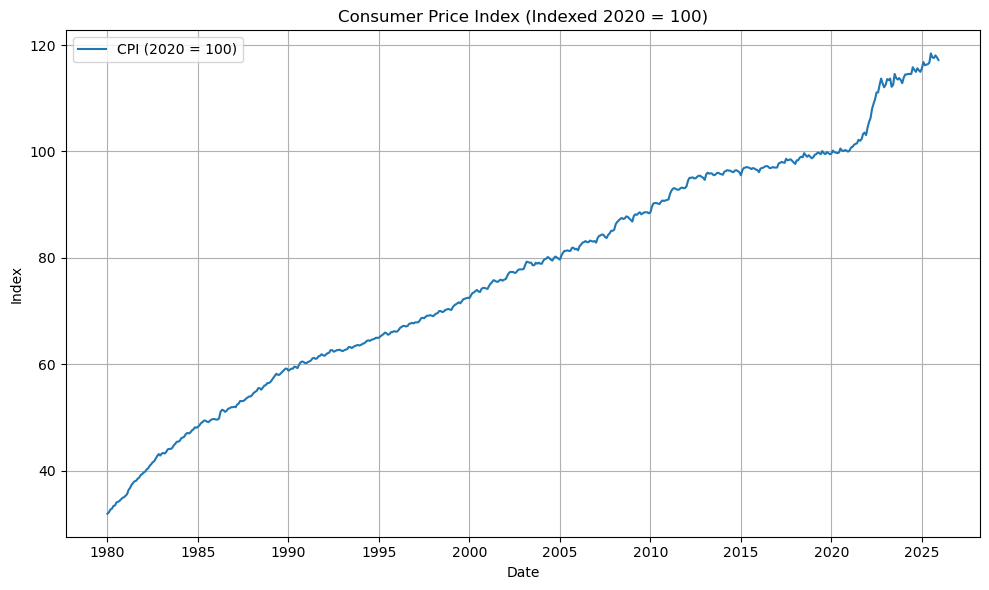

In [1]:
# Subsection 1.1.1

import pandas as pd
import matplotlib.pyplot as plt
from dstapi import DstApi


# 1. Load CPI data directly using DSTAPI
api = DstApi("PRIS113")

params = {
    "table": "PRIS113",
    "format": "BULK",
    "lang": "da",
    "variables": [
        {"code": "TYPE", "values": ["INDEKS"]},
        {"code": "Tid", "values": ["*"]}
    ]
}

df_raw = api.get_data(params=params)


# 2. Clean and prepare the data
df_raw["CPI_Raw"] = pd.to_numeric(
    df_raw["INDHOLD"]
        .astype(str)
        .replace("..", pd.NA)
        .str.replace(",", ".", regex=False),
    errors="coerce"
)

# Convert monthly time format (e.g. 2001M03) to datetime
df_raw["Date"] = pd.to_datetime(df_raw["TID"], format="%YM%m")

# Keep only what we need
df = df_raw[["Date", "CPI_Raw"]].dropna().sort_values("Date")


# 3. Index CPI to 100 on average in 2020
avg_2020 = df[df["Date"].dt.year == 2020]["CPI_Raw"].mean()

df["CPI_2020"] = (df["CPI_Raw"] / avg_2020) * 100


# 4. Plot the result
plt.figure(figsize=(10, 6))
plt.plot(df["Date"], df["CPI_2020"], label="CPI (2020 = 100)")
plt.title("Consumer Price Index (Indexed 2020 = 100)")
plt.xlabel("Date")
plt.ylabel("Index")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


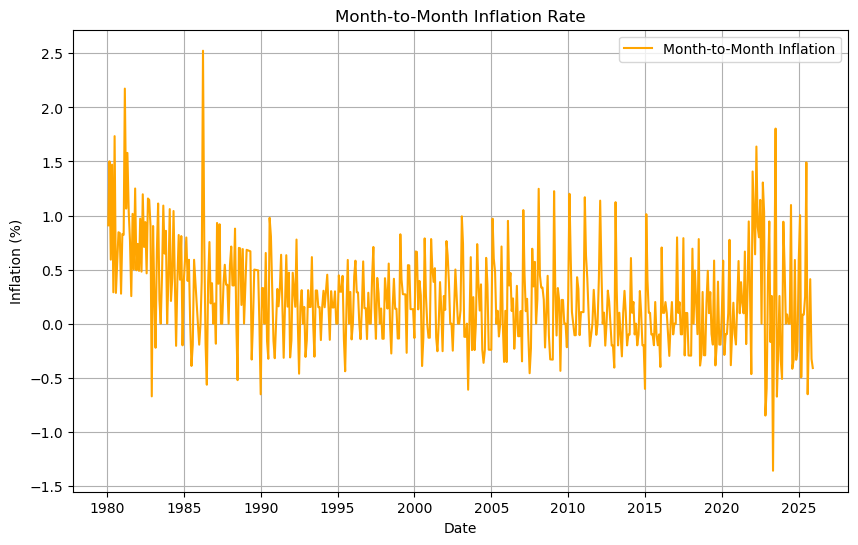

Latest monthly inflation: -0.41084634346754134


In [2]:
#Subsection 1.1.2
df['Inflation_m2m'] = df['CPI_Raw'].pct_change() * 100

# Plotting the month-to-month inflation
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Inflation_m2m'], label='Month-to-Month Inflation', color='orange')

plt.title("Month-to-Month Inflation Rate")
plt.xlabel("Date")
plt.ylabel("Inflation (%)")
plt.legend()
plt.grid(True)
plt.show()

# Checking the latest value to see if it matches expectations
print("Latest monthly inflation:", df['Inflation_m2m'].iloc[-1])

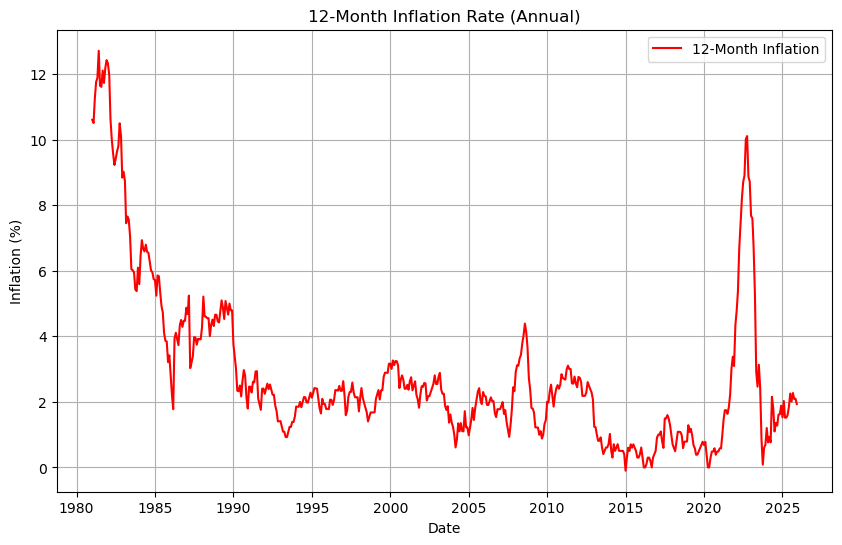

Peak inflation was 12.72% in June 1981.


In [3]:
#Subsection 1.1.3 - The 12-month inflation rate

# Formula: (Pt / Pt-12) - 1
df['Inflation_12m'] = df['CPI_Raw'].pct_change(12) * 100

# Plotting the 12-month inflation
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Inflation_12m'], label='12-Month Inflation', color='red')

plt.title("12-Month Inflation Rate (Annual)")
plt.xlabel("Date")
plt.ylabel("Inflation (%)")
plt.legend()
plt.grid(True)
plt.show()

# Find the peak of the surge
peak_inflation = df.loc[df['Inflation_12m'].idxmax()]
print(f"Peak inflation was {peak_inflation['Inflation_12m']:.2f}% in {peak_inflation['Date'].strftime('%B %Y')}.")

The figure shows that the post-pandemic inflation surge ended in late 2023

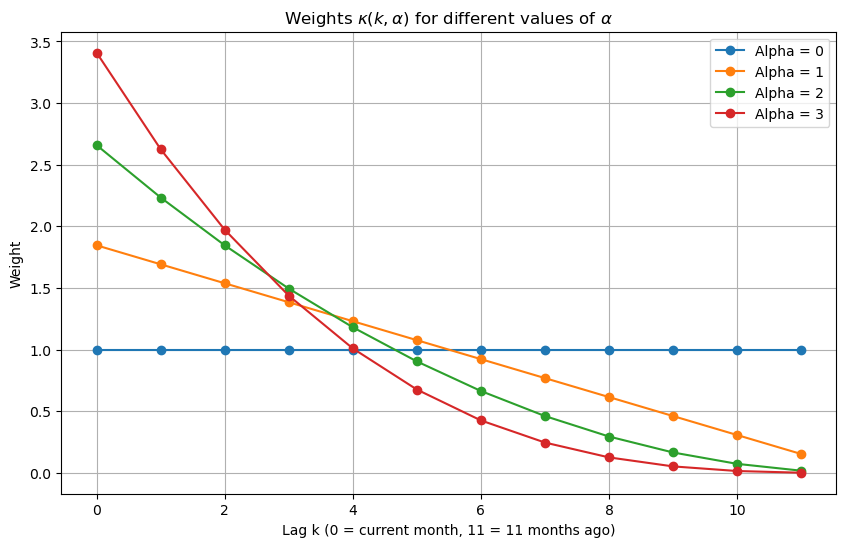

In [4]:
#Subsection 1.2.1
import numpy as np

# 1. Define the weight function kappa
def get_weights(alpha, T=12):
    k = np.arange(0, T)
    
    # Calculate numerator: (T-k)^alpha
    numerator = (T - k) ** alpha
    
    # Calculate denominator: Sum of all numerators
    denominator = np.sum(numerator)
    
    # Calculate kappa
    kappa = (numerator / denominator) * T
    return kappa

# 2. Plot the weights for different alphas
alphas = [0, 1, 2, 3]
plt.figure(figsize=(10, 6))

for alpha in alphas:
    weights = get_weights(alpha)
    plt.plot(np.arange(0, 12), weights, marker='o', label=f'Alpha = {alpha}')

plt.title("Weights $\kappa(k, \\alpha)$ for different values of $\\alpha$")
plt.xlabel("Lag k (0 = current month, 11 = 11 months ago)")
plt.ylabel("Weight")
plt.legend()
plt.grid(True)
plt.show()

In [5]:
#Subsection 1.2.2 - Instantaneous Inflation Calculation

# 1. Define Weights Function
def get_weights(alpha, T=12):
    k = np.arange(0, T)
    numerator = (T - k) ** alpha
    return (numerator / numerator.sum()) * T

# 2. Define Weighted Inflation Calculator
def calc_weighted_inflation(window, weights):
    aligned_weights = weights[::-1] 
    term = (1 + window/100) ** aligned_weights
    return (np.prod(term) - 1) * 100

# 3. Compute and Update the Main DataFrame
alphas = [0, 1, 2, 3]

for alpha in alphas:
    w = get_weights(alpha)
    col_name = f'Inflation_Instant_{alpha}'
    
    # Update the main df directly
    df[col_name] = df['Inflation_m2m'].rolling(12).apply(
        calc_weighted_inflation, args=(w,), raw=True
    )

# 4. Output the result as a table (showing the new columns)
df[['Date'] + [f'Inflation_Instant_{a}' for a in alphas]].tail(12)

,Date,Inflation_Instant_0,Inflation_Instant_1,Inflation_Instant_2,Inflation_Instant_3
541,2025-01-01,1.528014,1.222540,1.237912,1.380051
128,2025-02-01,2.027027,2.865203,3.687085,4.521928
114,2025-03-01,1.520270,1.609763,1.669876,1.683815
396,2025-04-01,1.518987,1.529927,1.533391,1.491896
534,2025-05-01,1.603376,1.450223,1.416009,1.340665
253,2025-06-01,1.856540,1.668287,1.766901,1.797479
546,2025-07-01,2.253756,4.189758,5.467897,6.529741
267,2025-08-01,2.011735,2.584716,2.673009,2.571972
138,2025-09-01,2.270816,2.115763,1.860797,1.519447
121,2025-10-01,2.090301,2.537455,2.504385,2.420579


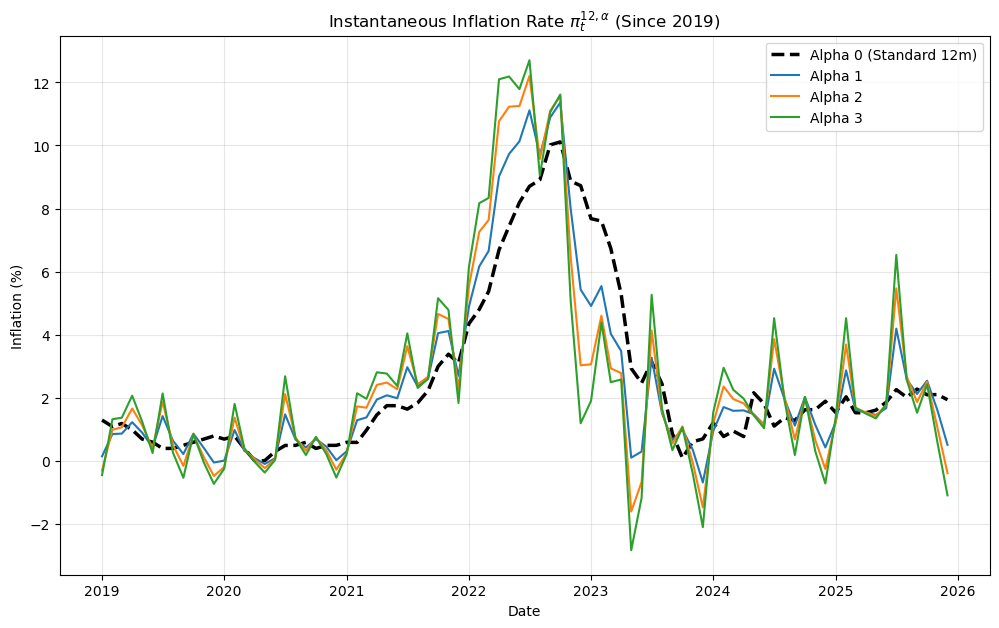

In [6]:
# Subsection 1.2.3 

# 1. Filter for data since 2019
plot_df = df[df['Date'].dt.year >= 2019].copy()

# 2. Create the plot
plt.figure(figsize=(12, 7))

# Plot Alpha 0 (Standard 12m) with a distinct style
plt.plot(plot_df['Date'], plot_df['Inflation_Instant_0'], 
         label='Alpha 0 (Standard 12m)', color='black', linewidth=2.5, linestyle='--')

# Plot the weighted versions (Alpha 1, 2, 3)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c'] # Blue, Orange, Green (Hex-codes)
for i, alpha in enumerate([1, 2, 3]):
    plt.plot(plot_df['Date'], plot_df[f'Inflation_Instant_{alpha}'], 
             label=f'Alpha {alpha}', color=colors[i], linewidth=1.5)

# 3. Styling
plt.title(r"Instantaneous Inflation Rate $\pi_t^{12,\alpha}$ (Since 2019)")
plt.xlabel("Date")
plt.ylabel("Inflation (%)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Instantaneous inflation shows the surge ended by early 2023, months before the annual rate reached the 2% target. It demonstrates that price momentum had already stabilized while the annual measure remained inflated by the "base effect" of high prices from the previous year.

Fetching data...
 -> Processing CPI Total (000000)...
 -> Processing Excl. Energy (151000)...
 -> Processing Core (Excl. Energy & Food) (141000)...


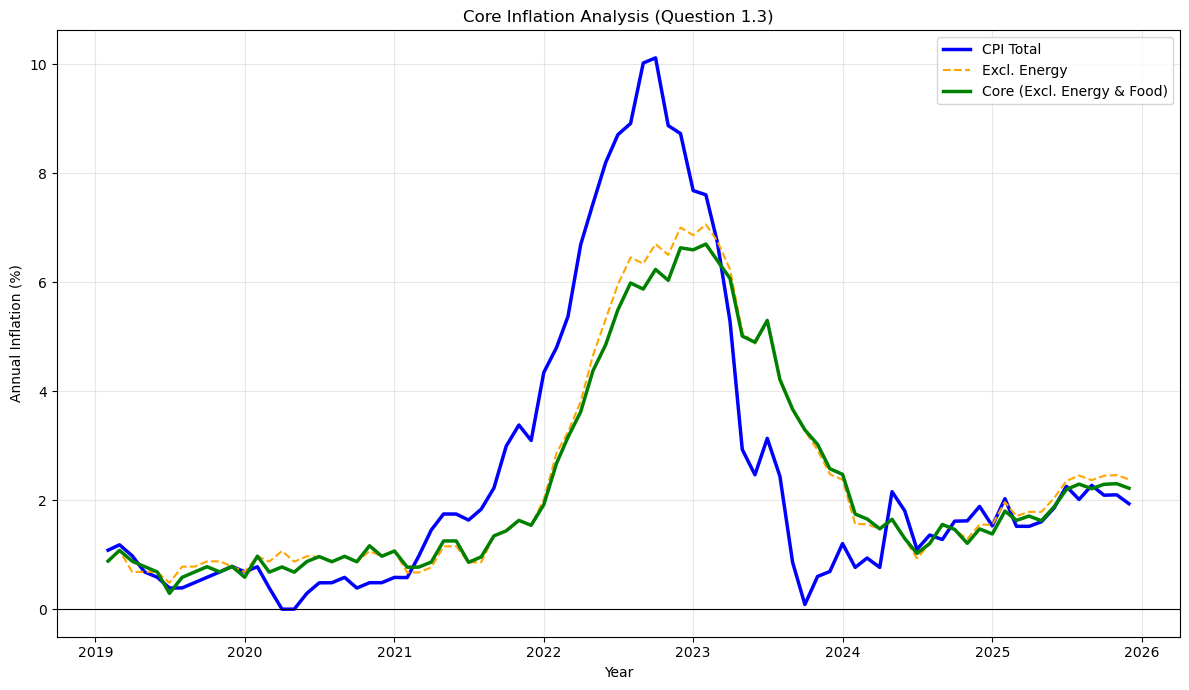

In [7]:
# Question 1.3: Core Inflation Analysis

categories = {
    "000000": "CPI Total",
    "151000": "Excl. Energy",
    "141000": "Core (Excl. Energy & Food)"
}


# 2. Function to fetch and clean data for ONE category
def get_inflation_series(group_code):
    api = DstApi("PRIS111")

    params = {
        "table": "PRIS111",
        "format": "BULK",
        "lang": "da",
        "variables": [
            {"code": "VAREGR", "values": [group_code]},
            {"code": "ENHED", "values": ["100"]},
            {"code": "Tid", "values": [">2018M01"]}
        ]
    }

    # Fetch data using DSTAPI
    df = api.get_data(params=params)

    # Create Date column
    df["Date"] = pd.to_datetime(df["TID"], format="%YM%m")

    # Clean numeric data (handle commas and missing values)
    df["Index"] = pd.to_numeric(
        df["INDHOLD"]
            .astype(str)
            .replace("..", pd.NA)
            .str.replace(",", ".", regex=False),
        errors="coerce"
    )

    # Calculate year-over-year inflation
    df = df.sort_values("Date")
    df["Inflation"] = df["Index"].pct_change(12) * 100

    # Keep data from 2019 onward
    df_clean = df[df["Date"] >= "2019-01-01"].copy()

    return df_clean


# 3. Main loop to plot all series
plt.figure(figsize=(12, 7))

print("Fetching data...")

for code, label in categories.items():
    print(f" -> Processing {label} ({code})...")

    df = get_inflation_series(code)

    if code == "141000":  # Core inflation
        plt.plot(df["Date"], df["Inflation"], label=label, linewidth=2.5, color="green")
    elif code == "000000":  # Total CPI
        plt.plot(df["Date"], df["Inflation"], label=label, linewidth=2.5, color="blue")
    else:  # Excluding energy
        plt.plot(df["Date"], df["Inflation"], label=label, linestyle="--", color="orange")


# 4. Final styling
plt.title("Core Inflation Analysis (Question 1.3)")
plt.xlabel("Year")
plt.ylabel("Annual Inflation (%)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.axhline(0, color="black", linewidth=0.8)
plt.tight_layout()
plt.show()


The right-skewed histogram confirms inflation was broad-based across almost all categories, while the extreme outliers in energy and food staples identify global supply-side shocks as the primary drivers of the surge.

Showing data for: 2025-12-01


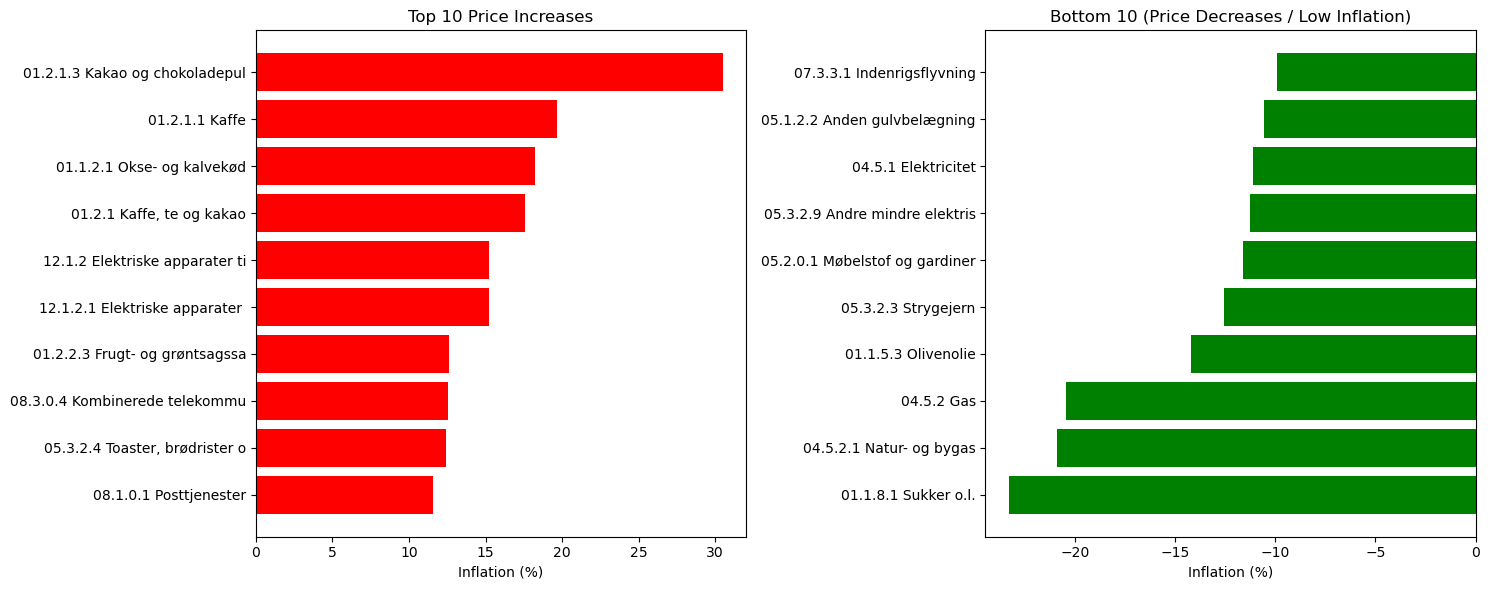

In [8]:
# Subsection 1.4 - Top and Bottom Inflation Categories


def answer_q1_4():

    # 1. Fetch CPI data for ALL product groups
    api = DstApi("PRIS111")

    params = {
        "table": "PRIS111",
        "format": "BULK",
        "lang": "da",
        "variables": [
            {"code": "VAREGR", "values": ["*"]},
            {"code": "ENHED", "values": ["100"]},
            {"code": "Tid", "values": [">2020M01"]}
        ]
    }

    df = api.get_data(params=params)

    # 2. Rename columns for clarity
    df = df.rename(columns={
        "VAREGR": "Category",
        "ENHED": "Unit",
        "TID": "Time",
        "INDHOLD": "Value"
    })

    # 3. Clean and prepare data
    df["Date"] = pd.to_datetime(df["Time"], format="%YM%m")

    df["Value"] = pd.to_numeric(
        df["Value"]
            .astype(str)
            .replace("..", pd.NA)
            .str.replace(",", ".", regex=False),
        errors="coerce"
    )

    # Remove missing values
    df = df.dropna(subset=["Value"])

    # 4. Calculate 12-month inflation
    df = df.sort_values(["Category", "Date"])
    df["Inflation"] = df.groupby("Category")["Value"].pct_change(12) * 100

    # 5. Select latest month
    latest_date = df["Date"].max()
    print(f"Showing data for: {latest_date.date()}")

    latest_df = df[df["Date"] == latest_date].dropna(subset=["Inflation"])
    latest_df = latest_df.sort_values("Inflation", ascending=False)

    top_10 = latest_df.head(10)
    bottom_10 = latest_df.tail(10)

    # 6. Plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    ax1.barh(top_10["Category"].astype(str).str[:30], top_10["Inflation"], color="red")
    ax1.set_title("Top 10 Price Increases")
    ax1.set_xlabel("Inflation (%)")
    ax1.invert_yaxis()

    ax2.barh(bottom_10["Category"].astype(str).str[:30], bottom_10["Inflation"], color="green")
    ax2.set_title("Bottom 10 (Price Decreases / Low Inflation)")
    ax2.set_xlabel("Inflation (%)")
    ax2.invert_yaxis()

    plt.tight_layout()
    plt.show()


# Run the analysis
answer_q1_4()


Step 1: Fetching Danish CPI from Statistics Denmark...


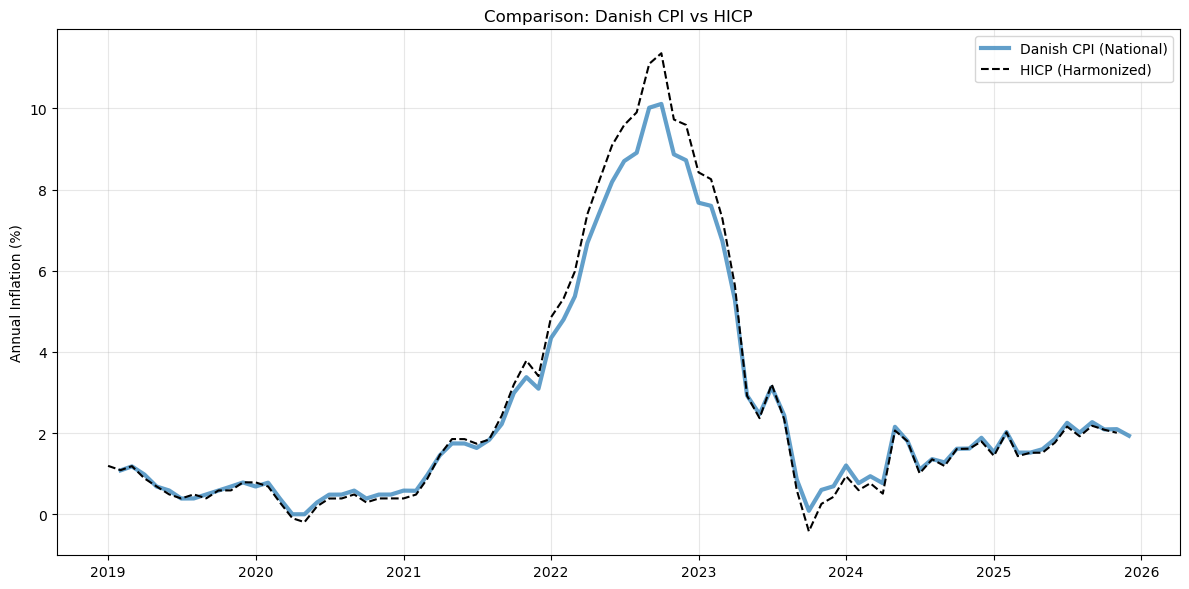

In [9]:
# Subsection 2.1 - Compare Danish CPI with HICP (Fixed)
from fredapi import Fred

# Step 1: Get Danish CPI (National Index) using DSTAPI
print("Step 1: Fetching Danish CPI from Statistics Denmark...")

api = DstApi("PRIS113")

params = {
    "table": "PRIS113",
    "format": "BULK",
    "lang": "da",
    "variables": [
        {"code": "TYPE", "values": ["INDEKS"]},
        {"code": "Tid", "values": [">2018M01"]}
    ]
}

df_cpi = api.get_data(params=params)

# Rename columns for clarity
df_cpi = df_cpi.rename(columns={
    "TID": "Date",
    "INDHOLD": "Index"
})

# Convert Date column (e.g. 2020M01 → datetime)
df_cpi["Date"] = pd.to_datetime(df_cpi["Date"], format="%YM%m")

# Clean numeric values
df_cpi["Index"] = pd.to_numeric(
    df_cpi["Index"]
        .astype(str)
        .replace("..", pd.NA)
        .str.replace(",", ".", regex=False),
    errors="coerce"
)

# Calculate year-over-year inflation
df_cpi = df_cpi.sort_values("Date").set_index("Date")
df_cpi["CPI_Inflation"] = df_cpi["Index"].pct_change(12) * 100

# Filter to 2019+
df_cpi_plot = df_cpi[df_cpi.index >= "2019-01-01"]


# Step 2: Get HICP (Harmonized Index) from FRED

try:
    with open("api.txt", "r") as f:
        api_key = f.read().strip()

    fred = Fred(api_key=api_key)

    # Danish HICP
    hicp_data = fred.get_series("CP0000DKM086NEST")

    df_hicp = pd.DataFrame({"HICP_Index": hicp_data})
    df_hicp.index.name = "Date"

    # Calculate year-over-year inflation
    df_hicp["HICP_Inflation"] = df_hicp["HICP_Index"].pct_change(12) * 100

    df_hicp_plot = df_hicp[df_hicp.index >= "2019-01-01"]


    # Step 3: Plot Comparison
    plt.figure(figsize=(12, 6))

    plt.plot(
        df_cpi_plot.index,
        df_cpi_plot["CPI_Inflation"],
        label="Danish CPI (National)",
        linewidth=3,
        alpha=0.7,
    )

    plt.plot(
        df_hicp_plot.index,
        df_hicp_plot["HICP_Inflation"],
        label="HICP (Harmonized)",
        color="black",
        linestyle="--",
    )

    plt.title("Comparison: Danish CPI vs HICP")
    plt.ylabel("Annual Inflation (%)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

except Exception:
    pass


Yes, the two indexes are highly comparable as they show nearly identical trends and levels

Fetching Danish CPI from Statistics Denmark...
Fetching data for other countries from FRED...


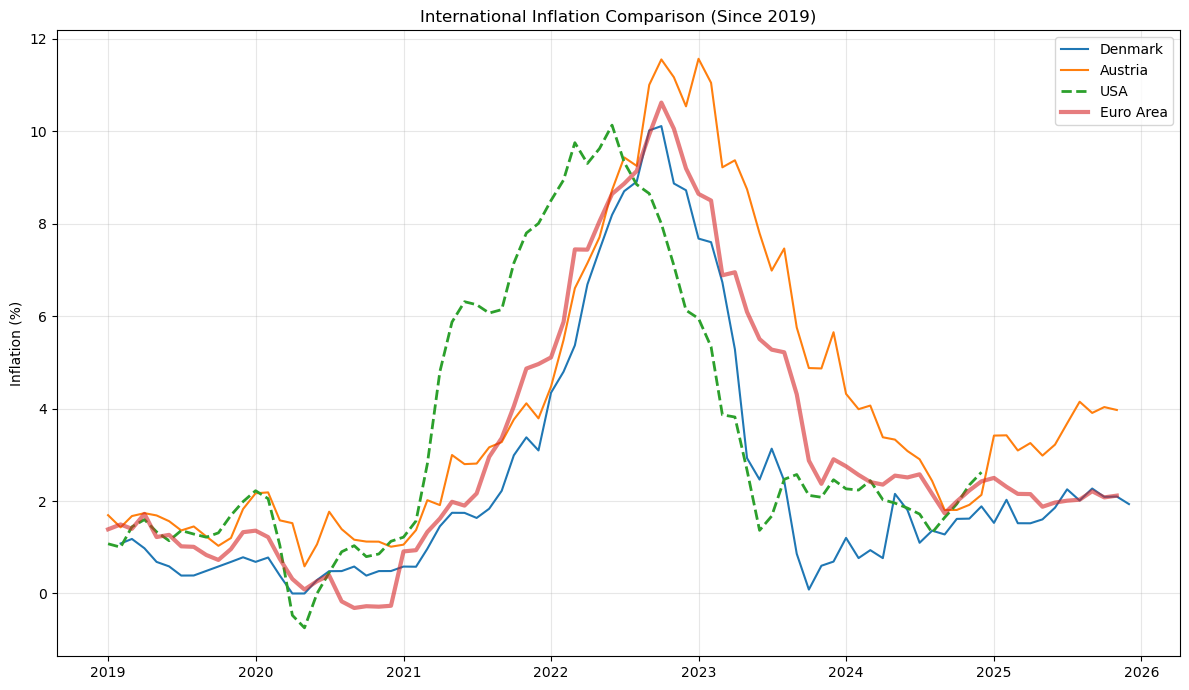


--- Summary Statistics (Min, Max, Mean) by Year ---
     Denmark              Austria                USA              Euro Area  \
         min    max  mean     min    max  mean   min    max  mean       min   
2019    0.39   1.18  0.71    1.03   1.83  1.49  1.00   1.99  1.37      0.73   
2020    0.00   0.78  0.42    0.59   2.19  1.39 -0.74   2.22  0.77     -0.31   
2021    0.58   3.38  1.85    1.06   4.11  2.76  1.22   8.01  5.33      0.91   
2022    4.34  10.11  7.68    4.48  11.55  8.59  6.13  10.13  8.69      5.11   
2023    0.09   7.68  3.37    4.87  11.57  7.78  1.37   5.95  3.03      2.37   
2024    0.77   2.16  1.37    1.81   4.32  2.93  1.32   2.62  2.03      1.74   
2025    1.52   2.27  1.89    2.98   4.15  3.56   NaN    NaN   NaN      1.88   

                   
        max  mean  
2019   1.72  1.20  
2020   1.36  0.26  
2021   4.96  2.59  
2022  10.62  8.36  
2023   8.64  5.46  
2024   2.75  2.36  
2025   2.50  2.13  


In [10]:
# Subsection 2.2 - Compare Inflation Across Countries


# 1. Load FRED API key
try:
    with open("api.txt", "r") as f:
        api_key = f.read().strip()
    fred = Fred(api_key=api_key)
except:
    print("Error: Could not find api.txt")
    api_key = None


if api_key:


    # 2. Fetch Danish CPI using DSTAPI
    print("Fetching Danish CPI from Statistics Denmark...")

    api = DstApi("PRIS113")

    params = {
        "table": "PRIS113",
        "format": "BULK",
        "lang": "da",
        "variables": [
            {"code": "TYPE", "values": ["INDEKS"]},
            {"code": "Tid", "values": [">2018M01"]}
        ]
    }

    df_dk = api.get_data(params=params)

    # Prepare Danish data
    df_dk["Date"] = pd.to_datetime(df_dk["TID"], format="%YM%m")
    df_dk["Index"] = pd.to_numeric(
        df_dk["INDHOLD"]
            .astype(str)
            .replace("..", pd.NA)
            .str.replace(",", ".", regex=False),
        errors="coerce"
    )

    df_dk = df_dk.sort_values("Date").set_index("Date")
    dk_inflation = df_dk["Index"].pct_change(12) * 100
    dk_inflation = dk_inflation[dk_inflation.index >= "2019-01-01"]



    # 3. Fetch inflation data for other countries from FRED
    print("Fetching data for other countries from FRED...")

    countries = {
        "Austria": "CP0000ATM086NEST",
        "USA": "CP0000USM086NEST",
        "Euro Area": "CP0000EZ19M086NEST"
    }

    all_data = {"Denmark": dk_inflation}

    for name, code in countries.items():
        try:
            series = fred.get_series(code)
            inflation = series.pct_change(12) * 100
            inflation = inflation[inflation.index >= "2019-01-01"]
            all_data[name] = inflation
        except Exception as e:
            print(f"Could not fetch {name}: {e}")


    # 4. Combine all countries into one DataFrame
    df_inflation = pd.DataFrame(all_data)


    # 5. Plotting
    plt.figure(figsize=(12, 7))

    for country in df_inflation.columns:
        if country == "USA":
            plt.plot(df_inflation.index, df_inflation[country],
                     label=country, linewidth=2, linestyle="--")
        elif country == "Euro Area":
            plt.plot(df_inflation.index, df_inflation[country],
                     label=country, linewidth=3, alpha=0.6)
        else:
            plt.plot(df_inflation.index, df_inflation[country], label=country)

    plt.title("International Inflation Comparison (Since 2019)")
    plt.ylabel("Inflation (%)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


    
    # 6. Summary statistics
    print("\n--- Summary Statistics (Min, Max, Mean) by Year ---")

    summary = df_inflation.groupby(df_inflation.index.year).agg(["min", "max", "mean"])
    print(summary.round(2))


The USA experienced the earliest and most aggressive surge, with a mean inflation of 5.33% already in 2021. Denmark and the Euro Area followed a similar trajectory, peaking in 2022 with mean rates around 8.5%, while Austria saw the most persistent inflation, maintaining a high mean of 7.78% into 2023. By 2024 and 2025, Denmark and the USA normalized more rapidly toward the 2% target, whereas Austria’s inflation remained comparatively elevated.

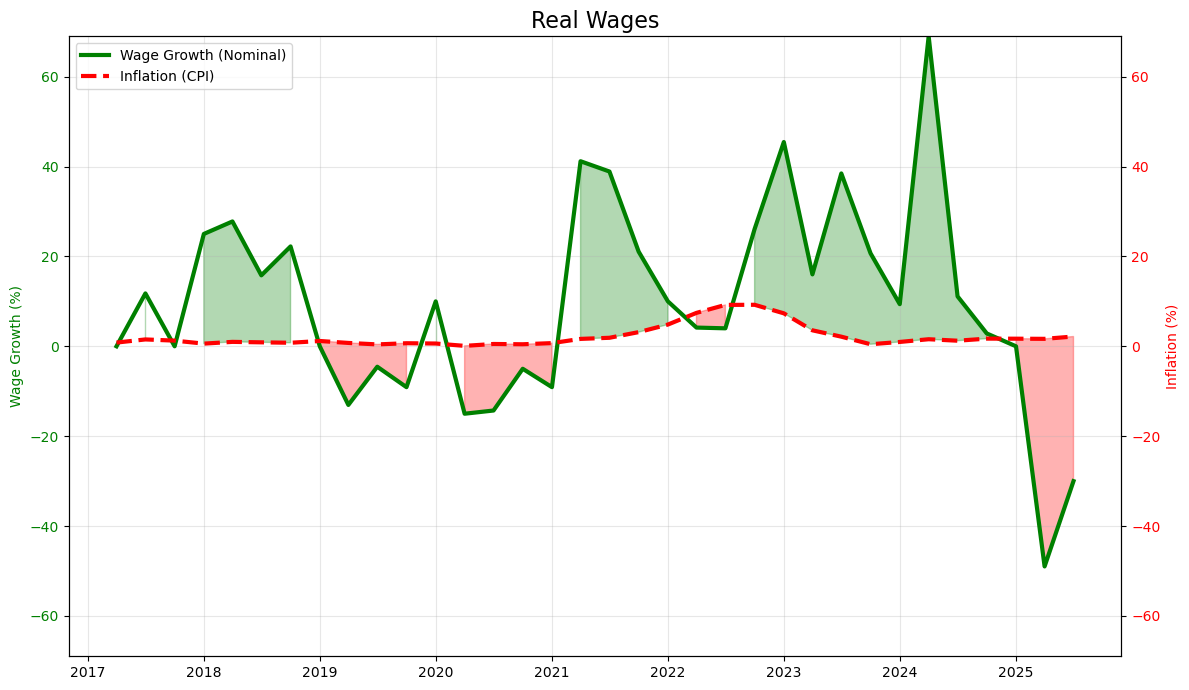

In [12]:
# Subsection 3 - Real Wage Growth vs Inflation

# The objective is to compare nominal wage growth with inflation in order 
# to assess changes in real wages over time. By aligning wage growth and inflation on a 
# common time scale and visualising them together, the code highlights periods when inflation 
# exceeds wage growth and purchasing power falls, as well as periods when wage growth outpaces 
# inflation and real wages improve.




# 1. Fetch Wage Data (ILON15)
api_wages = DstApi("ILON15")

params_wages = {
    "table": "ILON15",
    "format": "BULK",
    "lang": "da",
    "variables": [
        {"code": "ERHVERV", "values": ["TOT"]},
        {"code": "Tid", "values": [">2016K1"]}
    ]
}

df_wages = api_wages.get_data(params=params_wages)

df_wages["Wage_Index"] = pd.to_numeric(
    df_wages["INDHOLD"]
        .astype(str)
        .replace("..", pd.NA)
        .str.replace(",", ".", regex=False),
    errors="coerce"
)

# Convert quarterly time to dates
df_wages["Year"] = df_wages["TID"].str[:4]
df_wages["Q"] = df_wages["TID"].str[-1].astype(int)
df_wages["Month"] = df_wages["Q"] * 3 - 2
df_wages["Date"] = pd.to_datetime(
    df_wages["Year"] + "-" + df_wages["Month"].astype(str) + "-01"
)

df_wages = df_wages.sort_values("Date")

# Quarterly year-over-year wage growth
df_wages["Wage_Growth"] = df_wages["Wage_Index"].pct_change(4) * 100


# 2. Fetch CPI Data (PRIS113)  

api_cpi = DstApi("PRIS113")

params_cpi = {
    "table": "PRIS113",
    "format": "BULK",
    "lang": "da",
    "variables": [
        {"code": "TYPE", "values": ["INDEKS"]},
        {"code": "Tid", "values": [">2016M01"]}
    ]
}


df_cpi = api_cpi.get_data(params=params_cpi)

df_cpi["CPI_Index"] = pd.to_numeric(
    df_cpi["INDHOLD"]
        .astype(str)
        .replace("..", pd.NA)
        .str.replace(",", ".", regex=False),
    errors="coerce"
)

# Monthly time format
df_cpi["Date"] = pd.to_datetime(df_cpi["TID"], format="%YM%m")
df_cpi = df_cpi.sort_values("Date")

# Monthly year-over-year inflation
df_cpi["Inflation"] = df_cpi["CPI_Index"].pct_change(12) * 100

# Convert to quarterly (mean)
df_cpi_q = (
    df_cpi
    .set_index("Date")["Inflation"]
    .resample("QS")
    .mean()
    .reset_index()
)



# 3. Merge the statistics

df = pd.merge(
    df_wages[["Date", "Wage_Growth"]],
    df_cpi_q,
    on="Date",
    how="inner"
).dropna()



# 4. Shared y-axis limits (align zero)
y_min = min(df["Wage_Growth"].min(), df["Inflation"].min())
y_max = max(df["Wage_Growth"].max(), df["Inflation"].max())
abs_max = max(abs(y_min), abs(y_max))



# 5. Plot (Two Axes, Shared Zero)
fig, ax1 = plt.subplots(figsize=(12, 7))

# Wage growth (left axis)
ax1.plot(df["Date"], df["Wage_Growth"],
         color="green", linewidth=3, label="Wage Growth (Nominal)")
ax1.set_ylabel("Wage Growth (%)", color="green")
ax1.tick_params(axis="y", labelcolor="green")
ax1.set_ylim(-abs_max, abs_max)

# Inflation (right axis)
ax2 = ax1.twinx()
ax2.plot(df["Date"], df["Inflation"],
         color="red", linewidth=3, linestyle="--", label="Inflation (CPI)")
ax2.set_ylabel("Inflation (%)", color="red")
ax2.tick_params(axis="y", labelcolor="red")
ax2.set_ylim(-abs_max, abs_max)

# Fill real wage loss / gain
ax1.fill_between(
    df["Date"], df["Wage_Growth"], df["Inflation"],
    where=df["Inflation"] > df["Wage_Growth"],
    color="red", alpha=0.3
)

ax1.fill_between(
    df["Date"], df["Wage_Growth"], df["Inflation"],
    where=df["Wage_Growth"] > df["Inflation"],
    color="green", alpha=0.3
)

ax1.set_title("Real Wages", fontsize=16)
ax1.grid(True, alpha=0.3)

# Combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

plt.tight_layout()
plt.show()


The figure shows that the loss in real wages during 2022 was mainly driven by high inflation outpacing wage growth, rather than by falling wages. In contrast, the much larger decline observed in early 2025 reflects a sharp drop in nominal wage growth itself. Thus, 2022 represents an inflation-driven squeeze on purchasing power, while 2025 shows a genuine downturn in wages.